In [1]:
# Parameters
# Refer to injected parameters for any run.ipynb (similar cell below)
fname = 'BY4741_FKS1-HS2_single_ortho_anidulafungin_variant_data_merge.tsv'

min_input_readcount_high = 10
min_input_readcount_mid = 3

In [2]:
# Parameters
fname = "R1158_FKS2-HS2_single_ortho_dox_variant_data_merge.tsv"
min_input_readcount_high = 10
min_input_readcount_mid = 3


# Master notebook to analyze DMS data

## Import libraries

In [3]:
import os
import glob
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['svg.fonttype'] = 'none'
from upsetplot import from_indicators
from upsetplot import UpSet

## Functions

## Specify paths

In [4]:
metadata_path = 'data/'
variantdata_path = 'dimsum_output/variant_data/'
dimsumfitness_path = 'dimsum_output/fitness_data/'
expdesign_path = 'dimsum_expdesign/'
codon_table_path = 'data/general_use/ScerevisiaeTAXID559292_Cocoputs_codon_table.csv'

processed_data_outpath = 'processed_data/'
graph_outpath = 'graphs/'

## Analysis

In [5]:
f = variantdata_path+fname
pos_offset = {'FKS1-HS1': 639,
              'FKS1-HS2': 1353,
              'FKS2-HS1': 659,
              'FKS2-HS2': 1372
             }

### Get conditions from filename

In [6]:
cset = f.split('/')[-1].split('_')[:-3] # Extract conditions from name of file
cset_name = '_'.join(cset) # Basename based on conditions
strain, locus, pool_type, compound = [cset[i] for i in (0,1,2,-1)]
print(f'Strain: {strain}')
print(f'Locus: {locus}')
print(f'Pool type: {pool_type}')
print(f'Compound: {compound}')

Strain: R1158
Locus: FKS2-HS2
Pool type: single
Compound: dox


In [7]:
if pool_type == 'single':
    nhamaa = 1
elif pool_type == 'double':
    nhamaa = 2
else:
    print('Could not determine pool type')

### Create output folders if they don't already exist

In [8]:
if not os.path.exists(processed_data_outpath+cset_name):
    os.makedirs(processed_data_outpath+cset_name)
if not os.path.exists(graph_outpath+cset_name):
    os.makedirs(graph_outpath+cset_name)

### Read dataframe

In [9]:
df = pd.read_csv(f, sep='\t', header=0, dtype={'WT': 'boolean'}) # Boolean type supports missing data, helps pandas interpret column content
df

,nt_seq,aa_seq,WT,STOP,STOP_readthrough,Nham_nt,Nham_aa,Nmut_codons,output1dox1_e1_s1_b1_count,output1dox2_e1_s1_b2_count,...,output3dox3_e3_s1_b3_count,input1_e1_s0_bNA_count,input2_e2_s0_bNA_count,input3_e3_s0_bNA_count,barcode_valid,indel,constant_region,permitted,too_many_substitutions,mixed_substitutions
0,aaatggattaaaagatgtattatt,KWIKRCII,<NA>,False,False,12.0,6.0,7.0,118,77,...,102,315,188,216,True,False,True,True,False,False
1,aaatggattaaaagtgtattatt,KWIKSVL,<NA>,False,False,NaN,NaN,NaN,0,1,...,0,2,11,3,True,True,True,NaN,NaN,NaN
2,aaatggattaatagatgtattatt,KWINRCII,<NA>,False,False,13.0,6.0,7.0,0,0,...,0,0,0,1,True,False,True,True,False,False
3,aaatgtattaaaagatgtattatt,KCIKRCII,<NA>,False,False,13.0,7.0,8.0,1,0,...,0,0,0,0,True,False,True,True,False,False
4,aaattgattaaaagatgtattatt,KLIKRCII,<NA>,False,False,13.0,7.0,8.0,0,0,...,0,2,0,0,True,False,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4548,ttttgggttagacgttatacactc,FWVRRYTL,<NA>,False,False,3.0,1.0,2.0,2,0,...,1,3,1,1,True,False,True,True,False,False
4549,ttttgtgtgagacgttatacactc,FCVRRYTL,<NA>,False,False,3.0,2.0,2.0,0,1,...,1,6,5,2,True,False,True,True,False,False
4550,tttttgggtgagacgttatacactc,FLGETLYT,<NA>,False,False,NaN,NaN,NaN,1,0,...,1,1,0,0,True,True,True,NaN,NaN,NaN
4551,tttttggtgagacgttatacactc,FLVRRYTL,<NA>,False,False,3.0,2.0,2.0,6,4,...,0,5,1,5,True,False,True,True,False,False


In [10]:
# Extract sample names, based on naming pattern in experimental design file (input/output)
input_conditions = [x for x in df.columns if 'input' in x]
output_conditions = [x for x in df.columns if ('output' in x) & ('_e1_' in x)]
duplicated_output = [x for x in df.columns if ('output' in x) & ('_e1_' not in x)]
input_samples = [x.split('_')[0] for x in input_conditions]
output_samples = [x.split('_')[-2] for x in output_conditions]
conditions = input_samples+output_samples
print(conditions)

['input1', 'input2', 'input3', 'b1', 'b2', 'b3']


#### ⚠️ **Filtering step** ⚠️ - Formatting

In [11]:
# Drop redundant columns due to duplicates in experimental design file
df.drop(columns=duplicated_output, inplace=True)
df.rename(columns=lambda x: x.split('_')[0] if 'input' in x else x, inplace=True)
df.rename(columns=lambda x: x.split('_')[-2] if 'output' in x else x, inplace=True)

In [12]:
# Extract WT sequences (nucleotide and protein)
wtseq = df.loc[df.WT==True, 'nt_seq'].values[0]
wtaa = df.loc[df.WT==True, 'aa_seq'].values[0]
print(f'WT (nt): {wtseq} | (aa): {wtaa}')

WT (nt): gattgggtgagacgttatacactc | (aa): DWVRRYTL


### Mean readcount per variant (raw data)

This matrix shows the average readcount per unique nucleotide sequence per number of mutated codons across samples.

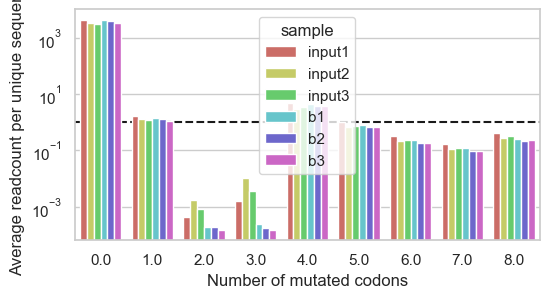

In [13]:
# Purge graph space
sns.set(rc = {'figure.figsize':(6,3)})
sns.set_theme(style='whitegrid')
f, ax = plt.subplots()

count_per_mut_codon = df.groupby('Nmut_codons')[conditions].count()
mean_rc_per_variant = df.groupby('Nmut_codons')[conditions].mean() / count_per_mut_codon
mean_rc_per_variant.reset_index(inplace=True)
mean_rc_long = mean_rc_per_variant.melt(id_vars=['Nmut_codons'], value_vars=conditions, var_name='sample')
sns.barplot(mean_rc_long, x='Nmut_codons',y='value',hue='sample',palette='hls')
plt.yscale('log')
plt.ylabel('Average readcount per unique sequence')
plt.xlabel('Number of mutated codons')
plt.axhline(y=1, linestyle='--', c='k', zorder=-10)

### Overrepresented variants (raw data)

The table below shows the 5 most represented sequences (mean readcount across samples) in % read depth per sample.

#### Overrepresented variants in input samples

In [14]:
overrep_index = df[input_samples].mean(axis=1).sort_values(ascending=False).index[:5]
overrep = 100*round(df.iloc[overrep_index][conditions] / df[conditions].sum(axis=0), 4)
pd.concat([overrep, df.iloc[overrep_index][['nt_seq', 'aa_seq', 'Nmut_codons']]], axis=1)

,input1,input2,input3,b1,b2,b3,nt_seq,aa_seq,Nmut_codons
1980,2.26,2.17,2.22,2.86,2.93,2.83,gattgggtgagacgttatacactc,DWVRRYTL,0.0
4450,2.13,1.88,2.03,2.51,2.63,2.43,ttgtgggtgagacgttatacactc,LWVRRYTL,1.0
2155,1.91,1.79,1.88,1.87,2.07,1.99,gattgggtgagacgttatttgctc,DWVRRYLL,1.0
2449,1.87,1.72,1.79,2.28,2.28,2.33,gattgggtgaggcgttatacactc,DWVRRYTL,1.0
1975,1.73,1.67,1.64,2.10,2.08,1.96,gattgggtgagacgttatacacgg,DWVRRYTR,1.0


#### Overrepresented variants in output samples

In [15]:
overrep_index = df[output_samples].mean(axis=1).sort_values(ascending=False).index[:5]
overrep = 100*round(df.iloc[overrep_index][conditions] / df[conditions].sum(axis=0), 4)
pd.concat([overrep, df.iloc[overrep_index][['nt_seq', 'aa_seq', 'Nmut_codons']]], axis=1)

,input1,input2,input3,b1,b2,b3,nt_seq,aa_seq,Nmut_codons
1980,2.26,2.17,2.22,2.86,2.93,2.83,gattgggtgagacgttatacactc,DWVRRYTL,0.0
4450,2.13,1.88,2.03,2.51,2.63,2.43,ttgtgggtgagacgttatacactc,LWVRRYTL,1.0
2449,1.87,1.72,1.79,2.28,2.28,2.33,gattgggtgaggcgttatacactc,DWVRRYTL,1.0
1975,1.73,1.67,1.64,2.10,2.08,1.96,gattgggtgagacgttatacacgg,DWVRRYTR,1.0
2155,1.91,1.79,1.88,1.87,2.07,1.99,gattgggtgagacgttatttgctc,DWVRRYLL,1.0


### Calculate % read depth per sample corresponding to variants with no indels + read count above threshold

In [16]:
# Sum all reads for each sample
# Check proportion that corresponds to variants with no indels
rcNoIndel = df[conditions].sum(axis=0).to_frame('Total_reads')
rcNoIndel['Reads_no_indels'] = df[df.indel == False][conditions].sum(axis=0)
rcNoIndel['Reads_no_indels_%'] = 100*round(rcNoIndel['Reads_no_indels']/rcNoIndel['Total_reads'], 3)

# Check proportion that corresponds to variants with a read count above threshold in all input samples
# Here we only show the variant surpassing the highest threshold = variants which will be labeled with a high confidence score
rcNoIndel['No_indels_acceptable_RC'] = df[((df[input_samples] > min_input_readcount_high).all(1)) & (df.indel == False)][conditions].sum(axis=0)
rcNoIndel['Acceptable_RC_over_no_indels_%'] = 100*round(rcNoIndel['No_indels_acceptable_RC']/rcNoIndel['Reads_no_indels'], 3)

# Export summary to csv
rcNoIndel.to_csv(processed_data_outpath+cset_name+'/read_count_no_indel.csv')
rcNoIndel

,Total_reads,Reads_no_indels,Reads_no_indels_%,No_indels_acceptable_RC,Acceptable_RC_over_no_indels_%
input1,183699,182184,99.2,179070,98.3
input2,149172,147788,99.1,133827,90.6
input3,137538,136260,99.1,129999,95.4
b1,152939,152163,99.5,151074,99.3
b2,134192,133767,99.7,132677,99.2
b3,122910,122533,99.7,121575,99.2


#### ⚠️ **Filtering step** ⚠️ - Discard variants with indels

In [17]:
# Keeping only variants with no indels
df.drop(df[df.indel].index, inplace=True)
df.reset_index(drop=True, inplace=True)
df

,nt_seq,aa_seq,WT,STOP,STOP_readthrough,Nham_nt,Nham_aa,Nmut_codons,b1,b2,b3,input1,input2,input3,barcode_valid,indel,constant_region,permitted,too_many_substitutions,mixed_substitutions
0,aaatggattaaaagatgtattatt,KWIKRCII,<NA>,False,False,12.0,6.0,7.0,118,77,102,315,188,216,True,False,True,True,False,False
1,aaatggattaatagatgtattatt,KWINRCII,<NA>,False,False,13.0,6.0,7.0,0,0,0,0,0,1,True,False,True,True,False,False
2,aaatgtattaaaagatgtattatt,KCIKRCII,<NA>,False,False,13.0,7.0,8.0,1,0,0,0,0,0,True,False,True,True,False,False
3,aaattgattaaaagatgtattatt,KLIKRCII,<NA>,False,False,13.0,7.0,8.0,0,0,0,2,0,0,True,False,True,True,False,False
4,aactggttgaaaagagttgttatt,NWLKRVVI,<NA>,False,False,13.0,6.0,7.0,0,0,0,1,0,0,True,False,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3907,ttttgggtgtatcgttatacactc,FWVYRYTL,<NA>,False,False,5.0,2.0,2.0,0,0,0,1,1,0,True,False,True,True,False,False
3908,ttttgggttagacgttatacactc,FWVRRYTL,<NA>,False,False,3.0,1.0,2.0,2,0,1,3,1,1,True,False,True,True,False,False
3909,ttttgtgtgagacgttatacactc,FCVRRYTL,<NA>,False,False,3.0,2.0,2.0,0,1,1,6,5,2,True,False,True,True,False,False
3910,tttttggtgagacgttatacactc,FLVRRYTL,<NA>,False,False,3.0,2.0,2.0,6,4,0,5,1,5,True,False,True,True,False,False


#### ⚠️ **Filtering step** ⚠️ - Keep only variants with at least 3 reads in at least 1 input replicate

In [18]:
inputRCdf = df[(df[input_samples] > 2).any(axis=1)]
inputRCdf

,nt_seq,aa_seq,WT,STOP,STOP_readthrough,Nham_nt,Nham_aa,Nmut_codons,b1,b2,b3,input1,input2,input3,barcode_valid,indel,constant_region,permitted,too_many_substitutions,mixed_substitutions
0,aaatggattaaaagatgtattatt,KWIKRCII,<NA>,False,False,12.0,6.0,7.0,118,77,102,315,188,216,True,False,True,True,False,False
5,aagtgggggagacgttatacactc,KWGRRYTL,<NA>,False,False,3.0,2.0,2.0,0,0,0,0,10,1,True,False,True,True,False,False
6,aagtgggtgacgcgttatacactc,KWVTRYTL,<NA>,False,False,4.0,2.0,2.0,0,0,0,4,12,2,True,False,True,True,False,False
7,aagtgggtgagaaagtatacactc,KWVRKYTL,<NA>,False,False,5.0,2.0,2.0,0,0,0,0,17,10,True,False,True,True,False,False
8,aagtgggtgagacgttatacactc,KWVRRYTL,<NA>,False,False,2.0,1.0,1.0,1,1,0,9,3,4,True,False,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3898,ttttgggtgagacgttattttctc,FWVRRYFL,<NA>,False,False,5.0,2.0,2.0,0,0,0,4,19,5,True,False,True,True,False,False
3901,ttttgggtgagaggttatacactc,FWVRGYTL,<NA>,False,False,3.0,2.0,2.0,0,0,1,5,11,5,True,False,True,True,False,False
3908,ttttgggttagacgttatacactc,FWVRRYTL,<NA>,False,False,3.0,1.0,2.0,2,0,1,3,1,1,True,False,True,True,False,False
3909,ttttgtgtgagacgttatacactc,FCVRRYTL,<NA>,False,False,3.0,2.0,2.0,0,1,1,6,5,2,True,False,True,True,False,False


### Label variants with confidence score (related to readcount)

In [19]:
def get_confidence_score(g, thresh_high, thresh_mid):
    # The read count in all input replicates is parsed to label each variant with a confidence score
    # Score is an integer for easy aggregation of synonymous codons
    if (g >= thresh_high).all():
        return 1 # high confidence score
    elif (g > thresh_mid).any():
        return 2 # medium confidence score
    else:
        return 3 # low confidence score

In [20]:
pd.set_option('mode.chained_assignment', None) # Disable settingWithCopy warning
inputRCdf['confidence_score'] = inputRCdf[input_samples].apply(lambda row: get_confidence_score(row, min_input_readcount_high, min_input_readcount_mid), axis=1)
inputRCdf

,nt_seq,aa_seq,WT,STOP,STOP_readthrough,Nham_nt,Nham_aa,Nmut_codons,b1,b2,...,input1,input2,input3,barcode_valid,indel,constant_region,permitted,too_many_substitutions,mixed_substitutions,confidence_score
0,aaatggattaaaagatgtattatt,KWIKRCII,<NA>,False,False,12.0,6.0,7.0,118,77,...,315,188,216,True,False,True,True,False,False,1
5,aagtgggggagacgttatacactc,KWGRRYTL,<NA>,False,False,3.0,2.0,2.0,0,0,...,0,10,1,True,False,True,True,False,False,2
6,aagtgggtgacgcgttatacactc,KWVTRYTL,<NA>,False,False,4.0,2.0,2.0,0,0,...,4,12,2,True,False,True,True,False,False,2
7,aagtgggtgagaaagtatacactc,KWVRKYTL,<NA>,False,False,5.0,2.0,2.0,0,0,...,0,17,10,True,False,True,True,False,False,2
8,aagtgggtgagacgttatacactc,KWVRRYTL,<NA>,False,False,2.0,1.0,1.0,1,1,...,9,3,4,True,False,True,True,False,False,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3898,ttttgggtgagacgttattttctc,FWVRRYFL,<NA>,False,False,5.0,2.0,2.0,0,0,...,4,19,5,True,False,True,True,False,False,2
3901,ttttgggtgagaggttatacactc,FWVRGYTL,<NA>,False,False,3.0,2.0,2.0,0,0,...,5,11,5,True,False,True,True,False,False,2
3908,ttttgggttagacgttatacactc,FWVRRYTL,<NA>,False,False,3.0,1.0,2.0,2,0,...,3,1,1,True,False,True,True,False,False,3
3909,ttttgtgtgagacgttatacactc,FCVRRYTL,<NA>,False,False,3.0,2.0,2.0,0,1,...,6,5,2,True,False,True,True,False,False,2


### Merge with dataframe of expected variants

In [21]:
# Dataframe containing all expected mutants for the different libraries (single, double, ortholog) is imported
# /!\ Important to note that I did not actually separate by type of library /!\
# "Double" mutants do not include single mutants
# "Ortho" are standalone (double mutants in orthologous sequences are duplicated in "double" and "ortho" seq types)
source = metadata_path+locus+f'/{locus}_var_df.csv'
vardf = pd.read_csv(source, header=0, index_col=0)
vardf

,seq_type,nt_seq,aa_pos,alt_codons,mutated_codon,combination
0,WT,gattgggtgagacgttatacactc,NaN,NaN,NaN,NaN
1,single,ttttgggtgagacgttatacactc,0.0,ttt,1.0,NaN
2,single,ttgtgggtgagacgttatacactc,0.0,ttg,1.0,NaN
3,single,ctttgggtgagacgttatacactc,0.0,ctt,1.0,NaN
4,single,ctgtgggtgagacgttatacactc,0.0,ctg,1.0,NaN
...,...,...,...,...,...,...
55760,ortho,gattgggttaatagatgtattatt,3.0,aat,2.0,NaN
55761,ortho,gattgggttaatagatgtattatt,4.0,aga,3.0,NaN
55762,ortho,gattgggttaatagatgtattatt,5.0,tgt,4.0,NaN
55763,ortho,gattgggttaatagatgtattatt,6.0,att,5.0,NaN


#### ⚠️ **Filtering step** ⚠️ - Keep only mutants corresponding to pool_type

In [22]:
# Depending on the type of pool (single or double), expected variants are filtered
# The dictionary specifies which sequence types must be kept
keep_seq_type = {'single' : ['WT', 'single', 'ortho'], 'double': ['WT', 'single', 'double']}
var_filtered_df = vardf[vardf.seq_type.isin(keep_seq_type[pool_type])]
len(var_filtered_df)

641

In [23]:
len(var_filtered_df.nt_seq.unique())

315

In [24]:
# The dataframe of sequenced variants ( with no indels and readcount > threshold in all input replicates) and the dataframe of expected mutants are compared
# The column 'Location' indicates if a variant is found only in the set of expected variants (left), only in the sequenced dataset (right), or in both (covered variants)
comparedf = pd.merge(left=var_filtered_df, right=inputRCdf, how='outer', on='nt_seq', indicator='Location')
comparedf

,seq_type,nt_seq,aa_pos,alt_codons,mutated_codon,combination,aa_seq,WT,STOP,STOP_readthrough,...,input2,input3,barcode_valid,indel,constant_region,permitted,too_many_substitutions,mixed_substitutions,confidence_score,Location
0,WT,gattgggtgagacgttatacactc,NaN,NaN,NaN,NaN,DWVRRYTL,True,False,False,...,3244.0,3047.0,True,False,True,True,False,False,1.0,both
1,single,ttttgggtgagacgttatacactc,0.0,ttt,1.0,NaN,FWVRRYTL,<NA>,False,False,...,2121.0,1923.0,True,False,True,True,False,False,1.0,both
2,single,ttgtgggtgagacgttatacactc,0.0,ttg,1.0,NaN,LWVRRYTL,<NA>,False,False,...,2807.0,2792.0,True,False,True,True,False,False,1.0,both
3,single,ctttgggtgagacgttatacactc,0.0,ctt,1.0,NaN,NaN,<NA>,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
4,single,ctgtgggtgagacgttatacactc,0.0,ctg,1.0,NaN,NaN,<NA>,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1556,NaN,ttttgggtgagacgttattttctc,NaN,NaN,NaN,NaN,FWVRRYFL,<NA>,False,False,...,19.0,5.0,True,False,True,True,False,False,2.0,right_only
1557,NaN,ttttgggtgagaggttatacactc,NaN,NaN,NaN,NaN,FWVRGYTL,<NA>,False,False,...,11.0,5.0,True,False,True,True,False,False,2.0,right_only
1558,NaN,ttttgggttagacgttatacactc,NaN,NaN,NaN,NaN,FWVRRYTL,<NA>,False,False,...,1.0,1.0,True,False,True,True,False,False,3.0,right_only
1559,NaN,ttttgtgtgagacgttatacactc,NaN,NaN,NaN,NaN,FCVRRYTL,<NA>,False,False,...,5.0,2.0,True,False,True,True,False,False,2.0,right_only


In [25]:
# From that we build a summary with number of variants and read counts across samples
# Careful, some variants and their associated reads are shared among different samples
seqdf = inputRCdf[conditions].astype(bool).sum(axis=0).to_frame('Filtered_sequenced_variants') # No duplicates in this dataframe - corresponds to sequenced variants (expected AND unexpected)
seqdf['Filtered_sequenced_variants_rc'] = inputRCdf[conditions].sum(axis=0)
seqdf['Usable_variants'] = comparedf[comparedf.Location.str.contains('both')].groupby('nt_seq')[conditions].first().astype(bool).sum(axis=0)
# Below we calculate how many variants (of the proper seq type) are found in our sequencing dataset after filtering steps
# Only the highest percentage value is relevant, since variants are shared between input and output samples (some of them being depleted after selection)
# Expected but unsequenced variants might have been absent from our initial libraries of mutants
seqdf['Covered_variants_%'] = 100*round(seqdf['Usable_variants']/len(var_filtered_df.nt_seq.unique()),3)
seqdf['Usable_variants_rc'] = comparedf[comparedf.Location.str.contains('both')].groupby('nt_seq')[conditions].first().sum(axis=0)
seqdf['Usable_variants_%rc'] = 100*round(seqdf['Usable_variants_rc']/seqdf['Filtered_sequenced_variants_rc'],3)
seqdf['Unsequenced_variants'] = comparedf[comparedf.Location.str.contains('left')].groupby('nt_seq')[conditions].first().astype(bool).sum(axis=0)
# Readcount for unsequenced variants is by definition = 0
seqdf['Unexpected_variants'] = comparedf[comparedf.Location.str.contains('right')][conditions].astype(bool).sum(axis=0)
seqdf['Unexpected_variants_rc'] = comparedf[comparedf.Location.str.contains('right')][conditions].sum(axis=0)
# %Readcount for unexpected variants is always 100 - %rc for covered variants

# Export summary
seqdf.to_csv(processed_data_outpath+cset_name+'/detected_variants.csv')
seqdf

,Filtered_sequenced_variants,Filtered_sequenced_variants_rc,Usable_variants,Covered_variants_%,Usable_variants_rc,Usable_variants_%rc,Unsequenced_variants,Unexpected_variants,Unexpected_variants_rc
input1,802,181264,242,76.8,177367.0,97.9,72,560,3897.0
input2,1106,146737,241,76.5,132318.0,90.2,72,865,14419.0
input3,1065,135458,239,75.9,128717.0,95.0,72,826,6741.0
b1,402,151441,239,75.9,149798.0,98.9,72,163,1643.0
b2,388,133063,234,74.3,131657.0,98.9,72,154,1406.0
b3,379,121920,235,74.6,120647.0,99.0,72,144,1273.0


### Read counts on **sequenced** variants

#### ⚠️ **Filtering step** ⚠️ - Keep only expected variants

In [26]:
pd.set_option('mode.chained_assignment', None) # Disable settingWithCopy warning
covereddf = comparedf[comparedf.Location.str.contains('both')].reset_index(drop=True)
covereddf[covereddf.duplicated(subset='nt_seq', keep=False)].head(5)

,seq_type,nt_seq,aa_pos,alt_codons,mutated_codon,combination,aa_seq,WT,STOP,STOP_readthrough,...,input2,input3,barcode_valid,indel,constant_region,permitted,too_many_substitutions,mixed_substitutions,confidence_score,Location
180,ortho,ggtgttattttgaatcaacaattt,0.0,ggt,1.0,NaN,GVILNQQF,<NA>,False,False,...,575.0,695.0,True,False,True,True,False,False,1.0,both
181,ortho,ggtgttattttgaatcaacaattt,1.0,gtt,2.0,NaN,GVILNQQF,<NA>,False,False,...,575.0,695.0,True,False,True,True,False,False,1.0,both
182,ortho,ggtgttattttgaatcaacaattt,2.0,att,3.0,NaN,GVILNQQF,<NA>,False,False,...,575.0,695.0,True,False,True,True,False,False,1.0,both
183,ortho,ggtgttattttgaatcaacaattt,3.0,ttg,4.0,NaN,GVILNQQF,<NA>,False,False,...,575.0,695.0,True,False,True,True,False,False,1.0,both
184,ortho,ggtgttattttgaatcaacaattt,4.0,aat,5.0,NaN,GVILNQQF,<NA>,False,False,...,575.0,695.0,True,False,True,True,False,False,1.0,both


In [27]:
cov_upset = covereddf.groupby('nt_seq').agg(dict(zip(conditions+['seq_type', 'confidence_score'], ['first']*(len(conditions)+2))))
cov_upset['mean_input'] = np.log10(cov_upset[input_samples].mean(axis=1).add(1))
cov_upset['mean_output'] = np.log10(cov_upset[output_samples].mean(axis=1).add(1))
cov_upset

,input1,input2,input3,b1,b2,b3,seq_type,confidence_score,mean_input,mean_output
nt_seq,,,,,,,,,,
aaatggattaaaagatgtattatt,315.0,188.0,216.0,118.0,77.0,102.0,ortho,1.0,2.381416,2.000000
aagtgggtgagacgttatacactc,9.0,3.0,4.0,1.0,1.0,0.0,single,2.0,0.801632,0.221849
aattgggtgagacgttatacactc,2.0,0.0,3.0,1.0,0.0,1.0,single,3.0,0.425969,0.221849
aattgggttaatagatgtattgtt,549.0,414.0,379.0,387.0,339.0,370.0,ortho,1.0,2.651601,2.563876
aattgggttaatagatgtgttatt,367.0,199.0,190.0,307.0,253.0,255.0,ortho,1.0,2.403121,2.435632
...,...,...,...,...,...,...,...,...,...,...
tcttggttgaaaagatgtgttatt,108.0,111.0,96.0,64.0,45.0,49.0,ortho,1.0,2.025306,1.729705
tggtgggtgagacgttatacactc,303.0,264.0,242.0,20.0,15.0,19.0,single,1.0,2.432435,1.278754
ttgtggattaaaagaactattatt,435.0,279.0,302.0,251.0,201.0,242.0,ortho,1.0,2.531053,2.366112


In [28]:
cov_upset.groupby('confidence_score').size()

confidence_score
1.0    223
2.0     14
3.0      6
dtype: int64

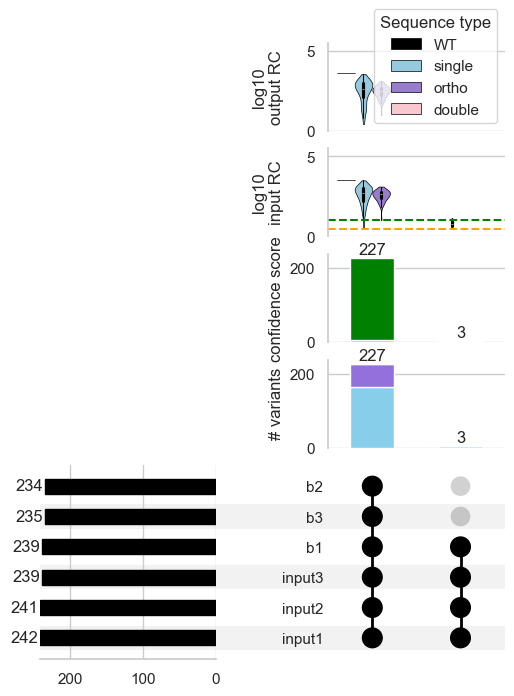

In [29]:
cov_upset[conditions] = cov_upset[conditions].astype(bool)
seq_types = ['WT', 'single', 'ortho', 'double']
seq_type_colors = ['black', 'skyblue', 'mediumpurple', 'pink']
cscores = [1,2,3]
cscore_colors = ['green','orange','red']

if pool_type == 'single':
    min_sub = 3
else:
    min_sub = 100

fig = plt.figure(figsize=(6, 8))
upset_obj = UpSet(from_indicators(conditions, data=cov_upset),
                   #show_percentages=True,
                   show_counts=True,
                   min_subset_size=min_sub,
                   sort_by='cardinality',
                   element_size=None,
                   intersection_plot_elements=0, # height of intersection barplot in matrix elements
                   totals_plot_elements = 2 # width of totals barplot in matrix elements
                  )

upset_obj.add_stacked_bars(by='seq_type',
                           colors=dict(zip(seq_types, seq_type_colors)),
                           elements=3
                          )

upset_obj.add_stacked_bars(by='confidence_score',
                           colors=dict(zip(cscores, cscore_colors)),
                           elements=3
                          )

upset_obj.add_catplot(value='mean_input', kind='violin', cut=0, density_norm='count',
                      hue='seq_type', hue_order=seq_types, palette=seq_type_colors,
                      linewidth=0.5,
                      elements=3 # height in number of matrix elements
                      )

upset_obj.add_catplot(value='mean_output', kind='violin', cut=0, density_norm='count',
                      hue='seq_type', hue_order=seq_types, palette=seq_type_colors,
                      linewidth=0.5,
                      elements=3 # height in number of matrix elements
                      )

d = upset_obj.plot(fig=fig) # Assigns all plots to a dictionary containing axes subplots - same keys as gridspec returned by upset_obj.make_grid()
ax0 = d['extra0'] # Key corresponding to 1st stacked barplot - type of sequence ('intersections' = intersection barplot)
ax1 = d['extra1'] # Key corresponding to 2nd stacked barplot (confidence score)
ax2 = d['extra2'] # Key corresponding to 1st catplot - read count for input samples
ax3 = d['extra3'] # Key corresponding to 2nd catplot - read count for output samples
ax0.legend().remove()
ax0.set_ylabel('# variants') # (unique nucleotide sequences)

ax1.legend().remove()
ax1.set_ylabel('confidence score')

ax2.legend().remove()
ax2.set(ylim=(0,5.5))
ax2.set_ylabel('log10\ninput RC')
ax2.axhline(y=np.log10(min_input_readcount_mid), linestyle='--', color=cscore_colors[1])
ax2.axhline(y=np.log10(min_input_readcount_high), linestyle='--', color=cscore_colors[0])

ax3.set(ylim=(0,5.5))
ax3.set_ylabel('log10\noutput RC')
ax3.legend(title='Sequence type')

plt.savefig(graph_outpath+cset_name+'/upset_variants_rc.svg', format='svg', dpi=300)

In [30]:
totrc = covereddf.groupby('nt_seq')[conditions].first().sum(axis=0).to_frame('total_readcount')
totrc['WT'] = covereddf[covereddf.WT==True][conditions].squeeze()
totrc['WT_%'] = 100*round(totrc['WT'] / totrc['total_readcount'], 3)
totrc['single_mut_readcount'] = covereddf[covereddf.seq_type=='single'].groupby('nt_seq')[conditions].first().sum(axis=0)
totrc['single_mut_readcount_%'] = 100*round(totrc['single_mut_readcount'] / totrc['total_readcount'], 3)
totrc['ortho_mut_readcount'] = covereddf[covereddf.seq_type=='ortho'].groupby('nt_seq')[conditions].first().sum(axis=0)
totrc['ortho_mut_readcount_%'] = 100*round(totrc['ortho_mut_readcount'] / totrc['total_readcount'], 3)
totrc['double_mut_readcount'] = covereddf[covereddf.seq_type=='double'].groupby('nt_seq')[conditions].first().sum(axis=0)
totrc['double_mut_readcount_%'] = 100*round(totrc['double_mut_readcount'] / totrc['total_readcount'], 3)
        
# Export summary - unexpected variants can have arisen through sequencing errors
totrc.to_csv(processed_data_outpath+cset_name+'/readcount_per_library.csv')
totrc

,total_readcount,WT,WT_%,single_mut_readcount,single_mut_readcount_%,ortho_mut_readcount,ortho_mut_readcount_%,double_mut_readcount,double_mut_readcount_%
input1,177367.0,4158.0,2.3,137696.0,77.6,35513.0,20.0,0.0,0.0
input2,132318.0,3244.0,2.5,105579.0,79.8,23495.0,17.8,0.0,0.0
input3,128717.0,3047.0,2.4,99987.0,77.7,25683.0,20.0,0.0,0.0
b1,149798.0,4367.0,2.9,119763.0,79.9,25668.0,17.1,0.0,0.0
b2,131657.0,3927.0,3.0,107310.0,81.5,20420.0,15.5,0.0,0.0
b3,120647.0,3473.0,2.9,95913.0,79.5,21261.0,17.6,0.0,0.0


The following is particularly important.

We add 1 read to all read counts to not have any null values (because of the dataframe's wide format).

Later on, when the selection coefficient is calculated, a zero could either mean that:

1. the sequence wasn't in the pool at t0
2. the sequence was in the pool at t0 but was not sequenced because of a low coverage
3. the sequence was so deleterious upon selective pressure that it is no longer sequenced at later timepoints

In [31]:
#pd.set_option('mode.chained_assignment', None) # Disable settingWithCopy warning
covereddf[conditions] += 1
covereddf[conditions]

,input1,input2,input3,b1,b2,b3
0,4159.0,3245.0,3048.0,4368.0,3928.0,3474.0
1,2797.0,2122.0,1924.0,2273.0,2181.0,1756.0
2,3909.0,2808.0,2793.0,3845.0,3529.0,2991.0
3,339.0,273.0,228.0,330.0,307.0,296.0
4,644.0,475.0,433.0,601.0,580.0,560.0
...,...,...,...,...,...,...
564,700.0,430.0,456.0,417.0,313.0,339.0
565,700.0,430.0,456.0,417.0,313.0,339.0
566,700.0,430.0,456.0,417.0,313.0,339.0
567,700.0,430.0,456.0,417.0,313.0,339.0


### Calculate frequencies (relative abundance of each variant)

In [32]:
abund = covereddf[conditions].div(covereddf.groupby('nt_seq')[conditions].first().sum(axis=0), axis=1)
abund.rename(columns=lambda x: x+'_abundance', inplace=True)
abund_conditions = [x+'_abundance' for x in conditions]

# Abundance values are added as columns on the existing dataframe
abundf = pd.concat([covereddf, abund], axis=1)
        
# Export dataframe
abundf.to_csv(processed_data_outpath+cset_name+'/abundance_all_libraries.csv')
#>>>>> DATAFRAME TO VISUALIZE DISTRIBUTION OF FREQUENCIES
abundf[abund_conditions]

,input1_abundance,input2_abundance,input3_abundance,b1_abundance,b2_abundance,b3_abundance
0,0.023416,0.024479,0.023635,0.029112,0.029780,0.028737
1,0.015748,0.016008,0.014919,0.015149,0.016535,0.014526
2,0.022009,0.021183,0.021658,0.025626,0.026755,0.024742
3,0.001909,0.002059,0.001768,0.002199,0.002328,0.002449
4,0.003626,0.003583,0.003358,0.004006,0.004397,0.004632
...,...,...,...,...,...,...
564,0.003941,0.003244,0.003536,0.002779,0.002373,0.002804
565,0.003941,0.003244,0.003536,0.002779,0.002373,0.002804
566,0.003941,0.003244,0.003536,0.002779,0.002373,0.002804
567,0.003941,0.003244,0.003536,0.002779,0.002373,0.002804


### Visualize distribution of frequencies

#### Convert to log10

In [33]:
log10_conditions = [x.replace('abundance', 'log10') for x in abund_conditions]
abundf[log10_conditions] = abundf[abund_conditions].transform(func='log10')

#### Conditions --> long format

In [34]:
abundlong = pd.melt(abundf.groupby(['nt_seq', 'seq_type'])[log10_conditions].first().reset_index(),
                    id_vars=['nt_seq','seq_type'], value_vars=log10_conditions, var_name='sample_id', value_name='abundance')
abundlong

,nt_seq,seq_type,sample_id,abundance
0,aaatggattaaaagatgtattatt,ortho,input1_log10,-2.749780
1,aagtgggtgagacgttatacactc,single,input1_log10,-4.249467
2,aattgggtgagacgttatacactc,single,input1_log10,-4.772346
3,aattgggttaatagatgtattgtt,ortho,input1_log10,-2.509105
4,aattgggttaatagatgtgttatt,ortho,input1_log10,-2.683620
...,...,...,...,...
1453,tcttggttgaaaagatgtgttatt,ortho,b3_log10,-3.383420
1454,tggtgggtgagacgttatacactc,single,b3_log10,-3.781360
1455,ttgtggattaaaagaactattatt,ortho,b3_log10,-2.696784
1456,ttgtgggtgagacgttatacactc,single,b3_log10,-1.606574


/home/rodur28/anaconda3/envs/dms-env/lib/python3.11/site-packages/seaborn/utils.py:493: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)
/tmp/ipykernel_23020/3281301397.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  fig.set_xticklabels([x.split('_')[0] for x in abundlong.sample_id.unique()])


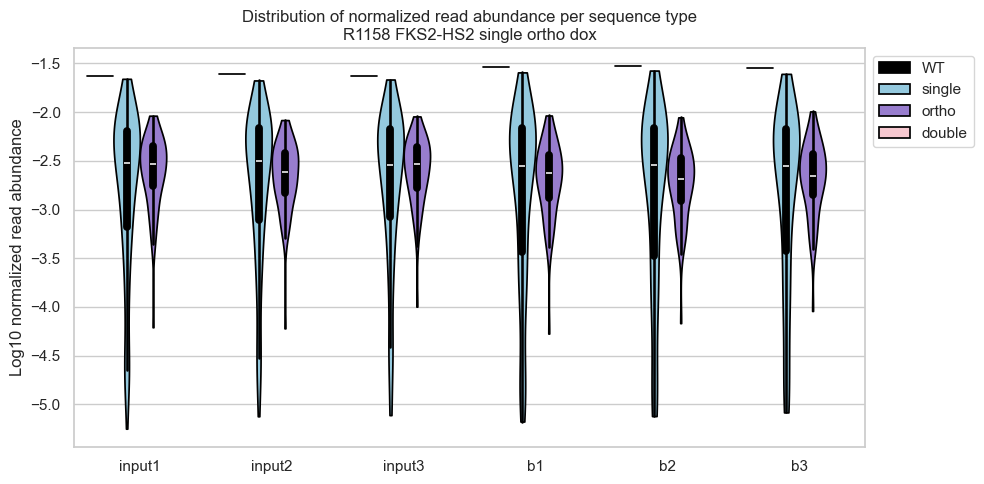

In [35]:
# Purge graph space
sns.set(rc = {'figure.figsize':(10,5)})
sns.set_theme(style='whitegrid')
f, ax = plt.subplots()

# Generate graph
fig = sns.violinplot(data=abundlong, x='sample_id', y='abundance',
                     hue='seq_type', hue_order=['WT', 'single', 'ortho', 'double'], palette=['black', 'skyblue', 'mediumpurple', 'pink'],
                     cut=0, # To make sure violins do not extend past the value range (because of log scale)
                     density_norm='count') # Width of violin proportional to number of observations

# Move legend
handles, labels = fig.get_legend_handles_labels()
sns.move_legend(fig, bbox_to_anchor=(1, 1), loc='upper left', title=None, frameon=True, handles=handles, labels=labels)

fig.axes.set(xlabel='', ylabel='Log10 normalized read abundance')
fig.set_xticklabels([x.split('_')[0] for x in abundlong.sample_id.unique()])
plt.title('Distribution of normalized read abundance per sequence type'+
         '\n'+' '.join(cset))
plt.tight_layout()

# Save graph to outpath
plt.savefig(graph_outpath+cset_name+'/abundance_distri.svg', format='svg', dpi=300)

### Add alt aminoacid and mutation type (synonymous / non-synonymous)

In [36]:
def get_mutation_type(alt, wt_aa, pos):
    if alt == wt_aa[int(pos)]:
        return 'synonymous'
    elif alt == '*':
        return 'stop'
    else:
        return 'non-synonymous'

In [37]:
abundf['alt_aa'] = abundf[abundf.seq_type != 'WT'].apply(lambda row: row['aa_seq'][int(row['aa_pos'])], axis=1)
abundf['mutation_type'] = abundf[abundf.seq_type != 'WT'].apply(lambda row: get_mutation_type(row.alt_aa, wtaa, row.aa_pos), axis=1)
abundf

,seq_type,nt_seq,aa_pos,alt_codons,mutated_codon,combination,aa_seq,WT,STOP,STOP_readthrough,...,b2_abundance,b3_abundance,input1_log10,input2_log10,input3_log10,b1_log10,b2_log10,b3_log10,alt_aa,mutation_type
0,WT,gattgggtgagacgttatacactc,NaN,NaN,NaN,NaN,DWVRRYTL,True,False,False,...,0.029780,0.028737,-1.630478,-1.611201,-1.626440,-1.535927,-1.526073,-1.541561,NaN,NaN
1,single,ttttgggtgagacgttatacactc,0.0,ttt,1.0,NaN,FWVRRYTL,<NA>,False,False,...,0.016535,0.014526,-1.802775,-1.795670,-1.826250,-1.819611,-1.781589,-1.837866,F,non-synonymous
2,single,ttgtgggtgagacgttatacactc,0.0,ttg,1.0,NaN,LWVRRYTL,<NA>,False,False,...,0.026755,0.024742,-1.657402,-1.674019,-1.664384,-1.591314,-1.572593,-1.606574,L,non-synonymous
3,single,atgtgggtgagacgttatacactc,0.0,atg,1.0,NaN,MWVRRYTL,<NA>,False,False,...,0.002328,0.002449,-2.719268,-2.686253,-2.752520,-2.657696,-2.633106,-2.611099,M,non-synonymous
4,single,gtttgggtgagacgttatacactc,0.0,gtt,1.0,NaN,VWVRRYTL,<NA>,False,False,...,0.004397,0.004632,-2.440582,-2.445722,-2.473967,-2.397335,-2.356817,-2.334202,V,non-synonymous
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,ortho,gattgggttaatagatgtattatt,3.0,aat,2.0,NaN,DWVNRCII,<NA>,False,False,...,0.002373,0.002804,-2.404369,-2.488947,-2.451490,-2.556074,-2.624700,-2.552191,N,non-synonymous
565,ortho,gattgggttaatagatgtattatt,4.0,aga,3.0,NaN,DWVNRCII,<NA>,False,False,...,0.002373,0.002804,-2.404369,-2.488947,-2.451490,-2.556074,-2.624700,-2.552191,R,synonymous
566,ortho,gattgggttaatagatgtattatt,5.0,tgt,4.0,NaN,DWVNRCII,<NA>,False,False,...,0.002373,0.002804,-2.404369,-2.488947,-2.451490,-2.556074,-2.624700,-2.552191,C,non-synonymous
567,ortho,gattgggttaatagatgtattatt,6.0,att,5.0,NaN,DWVNRCII,<NA>,False,False,...,0.002373,0.002804,-2.404369,-2.488947,-2.451490,-2.556074,-2.624700,-2.552191,I,non-synonymous


### Duplicate WT abundance for each position

In [38]:
# Turn WT sequence into list of codons with 0-based position
codcoord = [(i//3,wtseq[i:i+3]) for i in range(0,len(wtseq),3)]
print(codcoord)

[(0, 'gat'), (1, 'tgg'), (2, 'gtg'), (3, 'aga'), (4, 'cgt'), (5, 'tat'), (6, 'aca'), (7, 'ctc')]


In [39]:
# We create a custom list of columns to create a dataframe with WT codons
wtdf_cols = ['aa_pos', 'alt_codons', 'alt_aa', 'seq_type', 'mutation_type', 'WT', 'nt_seq', 'aa_seq', 'Nham_aa', 'confidence_score']

In [40]:
# A dataframe is created with 1 row per WT codon
pos_df = pd.DataFrame([[a, codcoord[a][1], wtaa[a], 'WT', 'synonymous', True, wtseq, wtaa, 0, abundf.loc[abundf.WT, 'confidence_score'][0]]
                       for a in range(0,len(wtaa))], columns=wtdf_cols)
for a in abund_conditions:
    pos_df[a] = abundf.loc[abundf.WT, a].values[0]
pos_df  

,aa_pos,alt_codons,alt_aa,seq_type,mutation_type,WT,nt_seq,aa_seq,Nham_aa,confidence_score,input1_abundance,input2_abundance,input3_abundance,b1_abundance,b2_abundance,b3_abundance
0,0,gat,D,WT,synonymous,True,gattgggtgagacgttatacactc,DWVRRYTL,0,1.0,0.023416,0.024479,0.023635,0.029112,0.02978,0.028737
1,1,tgg,W,WT,synonymous,True,gattgggtgagacgttatacactc,DWVRRYTL,0,1.0,0.023416,0.024479,0.023635,0.029112,0.02978,0.028737
2,2,gtg,V,WT,synonymous,True,gattgggtgagacgttatacactc,DWVRRYTL,0,1.0,0.023416,0.024479,0.023635,0.029112,0.02978,0.028737
3,3,aga,R,WT,synonymous,True,gattgggtgagacgttatacactc,DWVRRYTL,0,1.0,0.023416,0.024479,0.023635,0.029112,0.02978,0.028737
4,4,cgt,R,WT,synonymous,True,gattgggtgagacgttatacactc,DWVRRYTL,0,1.0,0.023416,0.024479,0.023635,0.029112,0.02978,0.028737
5,5,tat,Y,WT,synonymous,True,gattgggtgagacgttatacactc,DWVRRYTL,0,1.0,0.023416,0.024479,0.023635,0.029112,0.02978,0.028737
6,6,aca,T,WT,synonymous,True,gattgggtgagacgttatacactc,DWVRRYTL,0,1.0,0.023416,0.024479,0.023635,0.029112,0.02978,0.028737
7,7,ctc,L,WT,synonymous,True,gattgggtgagacgttatacactc,DWVRRYTL,0,1.0,0.023416,0.024479,0.023635,0.029112,0.02978,0.028737


In [41]:
withSyndf = pd.concat([abundf[abundf.WT.isnull()], pos_df], ignore_index=True)
withSyndf

,seq_type,nt_seq,aa_pos,alt_codons,mutated_codon,combination,aa_seq,WT,STOP,STOP_readthrough,...,b2_abundance,b3_abundance,input1_log10,input2_log10,input3_log10,b1_log10,b2_log10,b3_log10,alt_aa,mutation_type
0,single,ttttgggtgagacgttatacactc,0.0,ttt,1.0,NaN,FWVRRYTL,<NA>,False,False,...,0.016535,0.014526,-1.802775,-1.795670,-1.826250,-1.819611,-1.781589,-1.837866,F,non-synonymous
1,single,ttgtgggtgagacgttatacactc,0.0,ttg,1.0,NaN,LWVRRYTL,<NA>,False,False,...,0.026755,0.024742,-1.657402,-1.674019,-1.664384,-1.591314,-1.572593,-1.606574,L,non-synonymous
2,single,atgtgggtgagacgttatacactc,0.0,atg,1.0,NaN,MWVRRYTL,<NA>,False,False,...,0.002328,0.002449,-2.719268,-2.686253,-2.752520,-2.657696,-2.633106,-2.611099,M,non-synonymous
3,single,gtttgggtgagacgttatacactc,0.0,gtt,1.0,NaN,VWVRRYTL,<NA>,False,False,...,0.004397,0.004632,-2.440582,-2.445722,-2.473967,-2.397335,-2.356817,-2.334202,V,non-synonymous
4,single,gtgtgggtgagacgttatacactc,0.0,gtg,1.0,NaN,VWVRRYTL,<NA>,False,False,...,0.003252,0.003516,-2.597221,-2.582086,-2.614911,-2.538720,-2.487788,-2.454001,V,non-synonymous
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571,WT,gattgggtgagacgttatacactc,3.0,aga,NaN,NaN,DWVRRYTL,True,NaN,NaN,...,0.029780,0.028737,NaN,NaN,NaN,NaN,NaN,NaN,R,synonymous
572,WT,gattgggtgagacgttatacactc,4.0,cgt,NaN,NaN,DWVRRYTL,True,NaN,NaN,...,0.029780,0.028737,NaN,NaN,NaN,NaN,NaN,NaN,R,synonymous
573,WT,gattgggtgagacgttatacactc,5.0,tat,NaN,NaN,DWVRRYTL,True,NaN,NaN,...,0.029780,0.028737,NaN,NaN,NaN,NaN,NaN,NaN,Y,synonymous
574,WT,gattgggtgagacgttatacactc,6.0,aca,NaN,NaN,DWVRRYTL,True,NaN,NaN,...,0.029780,0.028737,NaN,NaN,NaN,NaN,NaN,NaN,T,synonymous


### Pair input/output samples

In [42]:
input_conditions = [x for x in abund_conditions if 'input' in x]
output_conditions = [x for x in abund_conditions if x not in input_conditions]
inpoutp_tuples = [(x, y) for x in input_conditions for y in output_conditions if x.split('_')[0][-1] == y.split('_')[0][-1]]
print(inpoutp_tuples)

[('input1_abundance', 'b1_abundance'), ('input2_abundance', 'b2_abundance'), ('input3_abundance', 'b3_abundance')]


### Calculate log2 fold-change (WT=0)

In [43]:
log2FC_conditions = ['Log2FC_'+ x[0].split('_')[0][-1] for x in inpoutp_tuples]
for i, v in enumerate(log2FC_conditions):
    withSyndf[v] = withSyndf[abund_conditions].apply(lambda row: math.log2(row[inpoutp_tuples[i][1]]/row[inpoutp_tuples[i][0]]), axis=1)
withSyndf[log2FC_conditions]

,Log2FC_1,Log2FC_2,Log2FC_3
0,-0.055927,0.046777,-0.038587
1,0.219540,0.336928,0.192041
2,0.204537,0.176550,0.469792
3,0.143660,0.295337,0.464289
4,0.194336,0.313254,0.534529
...,...,...,...
571,0.314092,0.282788,0.281964
572,0.314092,0.282788,0.281964
573,0.314092,0.282788,0.281964
574,0.314092,0.282788,0.281964


### Get number of mitotic generations from experimental design file

In [44]:
designdf = pd.read_csv(expdesign_path+cset_name+'_expdesign.txt', sep='\t', header=0)
nbgen = designdf.loc[(designdf.experiment_replicate == 1) & (designdf.selection_id == 1), 'generations'].tolist()
list_replicates = designdf.loc[(designdf.experiment_replicate == 1) & (designdf.selection_id == 1), 'selection_replicate'].tolist()
repgen = [(int(list_replicates[i]), nbgen[i]) for i in range(0,len(nbgen))]
print(repgen)

[(1, 3.972791786789202), (2, 3.964903103311578), (3, 4.095482729769815)]


### Normalize log2FC with number of mitotic generations

In [45]:
for i, v in enumerate(log2FC_conditions):
    withSyndf[v] = withSyndf[v].apply(lambda x: x/repgen[i][1] if int(v[-1])==repgen[i][0] else 'error')

withSyndf[log2FC_conditions]

,Log2FC_1,Log2FC_2,Log2FC_3
0,-0.014077,0.011798,-0.009422
1,0.055261,0.084978,0.046891
2,0.051484,0.044528,0.114710
3,0.036161,0.074488,0.113366
4,0.048917,0.079007,0.130517
...,...,...,...
571,0.079061,0.071323,0.068847
572,0.079061,0.071323,0.068847
573,0.079061,0.071323,0.068847
574,0.079061,0.071323,0.068847


### Calculate median of synonymous codons

Below we show that some synonymous variants appear to have an impact.

If their proportion in the population is small enough, taking the median from what appears to be almost always bimodal should be robust enough

In [46]:
synOnly = withSyndf[(withSyndf.aa_seq == wtaa) & (withSyndf.nt_seq != wtseq)
                   ].groupby('nt_seq')[['aa_pos','alt_aa','alt_codons'] + log2FC_conditions
                                        ].first().sort_values(by=['aa_pos','alt_aa','alt_codons']).reset_index()
len(synOnly)

11

In [47]:
synLong = pd.melt(synOnly, id_vars = 'nt_seq', value_vars = log2FC_conditions, var_name='replicate', value_name='norm_log2FC')
synLong

,nt_seq,replicate,norm_log2FC
0,gattgggttagaagatatactttg,Log2FC_1,0.008651
1,gattgggttagacgttatacactc,Log2FC_1,0.061256
2,gattgggtgaggcgttatacactc,Log2FC_1,0.066933
3,gattgggtgcggcgttatacactc,Log2FC_1,0.028563
4,gattgggtgcgtcgttatacactc,Log2FC_1,0.046561
5,gattgggtgagaaggtatacactc,Log2FC_1,0.036724
6,gattgggtgagacgttatacgctc,Log2FC_1,0.076220
7,gattgggtgagacgttatactctc,Log2FC_1,-0.043214
8,gattgggtgagacgttatacactg,Log2FC_1,0.054611
9,gattgggtgagacgttatacactt,Log2FC_1,0.152020


[Text(0.5, 0, 'log2FC / nb_gen')]

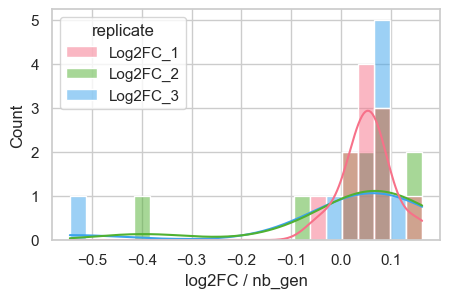

In [48]:
# Purge graph space
sns.set(rc = {'figure.figsize':(5,3)})
sns.set_theme(style='whitegrid')
f, ax = plt.subplots()

g = sns.histplot(synLong, x='norm_log2FC',
                 hue='replicate', palette='husl',
                 kde=True)

g.set(xlabel = 'log2FC / nb_gen')

In [49]:
medianSyn = synOnly[log2FC_conditions].median().squeeze()
medianSyn

Log2FC_1    0.054611
Log2FC_2    0.052709
Log2FC_3    0.069206
dtype: float64

### Calculate selection coefficient

In [50]:
selcoeff_conditions = [x.replace('Log2FC','selcoeff') for x in log2FC_conditions]
withSyndf[selcoeff_conditions] = withSyndf[log2FC_conditions].subtract(medianSyn, axis=1)
withSyndf[selcoeff_conditions]

,selcoeff_1,selcoeff_2,selcoeff_3
0,-0.068688,-0.040911,-0.078628
1,0.000650,0.032269,-0.022315
2,-0.003126,-0.008180,0.045504
3,-0.018450,0.021779,0.044160
4,-0.005694,0.026298,0.061311
...,...,...,...
571,0.024450,0.018614,-0.000359
572,0.024450,0.018614,-0.000359
573,0.024450,0.018614,-0.000359
574,0.024450,0.018614,-0.000359


### Compare replicates

Note: here the dataframe is reshaped to have 1 value per nucleotide sequence, with replicates in wide format. To minimize the number of steps, the same dataframe is used to calculate the correlation coefficient (using only the selection coefficients) and to look at the distribution.

In [51]:
gby_cols = ['Nham_aa','aa_seq','nt_seq']
permut = withSyndf.groupby(gby_cols)[selcoeff_conditions].first().reset_index()
permut.columns = [x[-1] if 'selcoeff' in x else x for x in permut.columns]
permut

,Nham_aa,aa_seq,nt_seq,1,2,3
0,0.0,DWVRRYTL,gattgggtgagaaggtatacactc,-0.017887,-0.000916,0.000000
1,0.0,DWVRRYTL,gattgggtgagacgttatacactc,0.024450,0.018614,-0.000359
2,0.0,DWVRRYTL,gattgggtgagacgttatacactg,0.000000,0.000000,0.007115
3,0.0,DWVRRYTL,gattgggtgagacgttatacactt,0.097410,0.109878,0.009746
4,0.0,DWVRRYTL,gattgggtgagacgttatacattg,0.036980,0.029226,0.034860
...,...,...,...,...,...,...
238,6.0,QWIKRCII,caatggattaaaagatgtattatt,-0.272226,-0.255668,-0.300445
239,6.0,RWIKRCII,agatggattaaaagatgtattatt,-0.161821,-0.207128,-0.238795
240,6.0,SWLKRCVI,tcttggttgaaaagatgtgttatt,-0.181086,-0.374679,-0.279884
241,8.0,GAILNQQF,ggtgctattttgaatcaacaattt,-0.081350,-0.109705,-0.094397


In [52]:
import itertools
rep_combinations = list(itertools.combinations(permut.columns[len(gby_cols):], 2))
rep_combinations

[('1', '2'), ('1', '3'), ('2', '3')]

In [53]:
from scipy import stats

pearson_dict = {}
for c in rep_combinations:
    pearson_dict[c] = stats.pearsonr(permut[c[0]], permut[c[1]])[0]
    # One possibility is to calculate this for stop, non-synonymous and synonymous separately
    # Pearson r for non-synonymous is the most important (the most affected by distribution of effects)
    # Depending on the level of noise, we could select the two lowest values, see if it's above a fixed threshold (both should be above .8)
    # then see which replicate was common to the 2 corresponding combinations and calculate the median from the two remaining
    
pearson_dict

{('1', '2'): 0.775770418211255,
 ('1', '3'): 0.8095764917062086,
 ('2', '3'): 0.8520787949963256}

In [54]:
if len(pearson_dict)>=1:
    pearson_df = pd.DataFrame.from_dict(pearson_dict, orient='index', columns=['Pearson']).reset_index(names='rep_compared')
    pearson_df[['replicate1','replicate2']] = pd.DataFrame(pearson_df.rep_compared.to_list())
    pearson_df.to_csv(processed_data_outpath+cset_name+'/Pearson_replicates.csv')

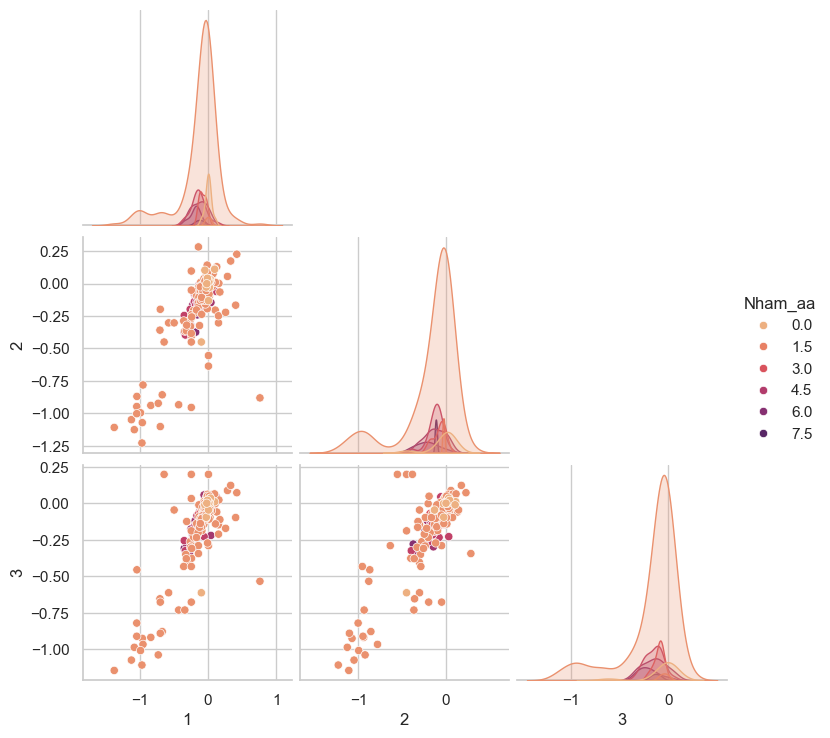

In [55]:
# Purge graph space
sns.set(rc = {'figure.figsize':(5,3)})
sns.set_theme(style='whitegrid')

fig = sns.pairplot(permut.sort_values(by='Nham_aa', ascending=False),
                   hue='Nham_aa', palette='flare',
                   corner=True)

# Code below does not work for all possible scenarios (replicate# does not necessarily match with facet#)
#for i in range(len(permut.columns[2:])):
#    for j in range(len(permut.columns[2:])):
#        if i < j:
#            fig.axes[j][i].annotate(round(pearson_dict[(str(i+1),str(j+1))],2), (-3,1))

In [56]:
permutlong = pd.melt(permut, id_vars = gby_cols, value_vars = [x[-1] for x in selcoeff_conditions], var_name='replicate', value_name='selcoeff')
permutlong

,Nham_aa,aa_seq,nt_seq,replicate,selcoeff
0,0.0,DWVRRYTL,gattgggtgagaaggtatacactc,1,-0.017887
1,0.0,DWVRRYTL,gattgggtgagacgttatacactc,1,0.024450
2,0.0,DWVRRYTL,gattgggtgagacgttatacactg,1,0.000000
3,0.0,DWVRRYTL,gattgggtgagacgttatacactt,1,0.097410
4,0.0,DWVRRYTL,gattgggtgagacgttatacattg,1,0.036980
...,...,...,...,...,...
724,6.0,QWIKRCII,caatggattaaaagatgtattatt,3,-0.300445
725,6.0,RWIKRCII,agatggattaaaagatgtattatt,3,-0.238795
726,6.0,SWLKRCVI,tcttggttgaaaagatgtgttatt,3,-0.279884
727,8.0,GAILNQQF,ggtgctattttgaatcaacaattt,3,-0.094397


In [57]:
permutlong_aa = permutlong.groupby(['Nham_aa','aa_seq','replicate'])[['selcoeff']].median().reset_index()
permutlong_aa

,Nham_aa,aa_seq,replicate,selcoeff
0,0.0,DWVRRYTL,1,0.003322
1,0.0,DWVRRYTL,2,0.006873
2,0.0,DWVRRYTL,3,-0.000179
3,1.0,*WVRRYTL,1,-0.700000
4,1.0,*WVRRYTL,2,-0.198425
...,...,...,...,...
559,8.0,GAILNQQF,2,-0.109705
560,8.0,GAILNQQF,3,-0.094397
561,8.0,GVILNQQF,1,-0.166390
562,8.0,GVILNQQF,2,-0.124118


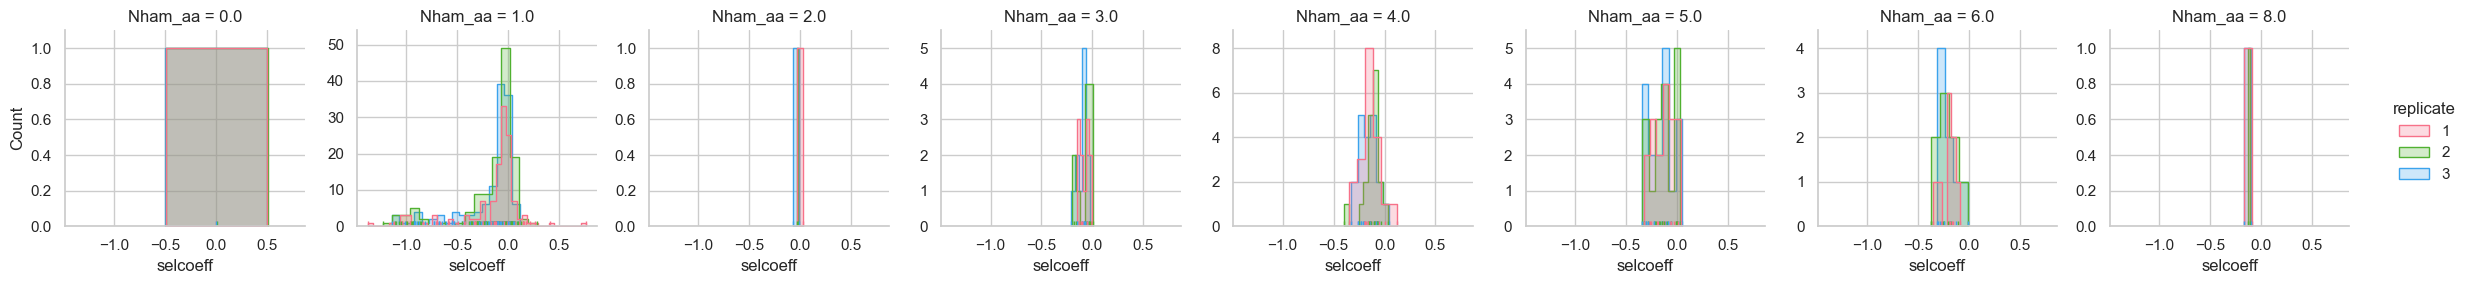

In [58]:
# Purge graph space
sns.set(rc = {'figure.figsize':(5,3)})
sns.set_theme(style='whitegrid')

fig = sns.displot(permutlong_aa, x='selcoeff', col = 'Nham_aa',
                  hue='replicate', palette='husl', rug=True,
                  element='step', common_norm=False,
                  common_bins=False, facet_kws={'sharex': True, 'sharey': False}, # different y scales for each facet
                  height=3
                 )

### Drop replicate if uncorrelated

#### ⚠️ **Filtering step** ⚠️

In [59]:
pearson_lowest = sorted(pearson_dict.items(), key=lambda x:x[1])
if (len(pearson_lowest) == 3) & (compound in ['caspofungin','micafungin','anidulafungin']):
    if (pearson_lowest[0][1] < .8) & (pearson_lowest[1][1] < .8):
        selcoeff_conditions.remove(f'selcoeff_{"".join(set(pearson_lowest[0][0]) & set(pearson_lowest[1][0]))}')

### Calculate median selection coefficient

In [60]:
withSyndf['median_s'] = withSyndf[selcoeff_conditions].median(axis=1)
withSyndf[selcoeff_conditions+['median_s']]

,selcoeff_1,selcoeff_2,selcoeff_3,median_s
0,-0.068688,-0.040911,-0.078628,-0.068688
1,0.000650,0.032269,-0.022315,0.000650
2,-0.003126,-0.008180,0.045504,-0.003126
3,-0.018450,0.021779,0.044160,0.021779
4,-0.005694,0.026298,0.061311,0.026298
...,...,...,...,...
571,0.024450,0.018614,-0.000359,0.018614
572,0.024450,0.018614,-0.000359,0.018614
573,0.024450,0.018614,-0.000359,0.018614
574,0.024450,0.018614,-0.000359,0.018614


### Export dataframe

In [61]:
withSyndf.to_csv(processed_data_outpath+cset_name+'/selcoeff_all_libraries.csv')

### Visualize single mutants as heatmap (codon level)

In [62]:
if pool_type == 'single':
    withWTdf = withSyndf[withSyndf.seq_type.isin(['WT','single'])]
else:
    withWTdf = withSyndf[withSyndf.Nham_aa <=1]
withWTdf

,seq_type,nt_seq,aa_pos,alt_codons,mutated_codon,combination,aa_seq,WT,STOP,STOP_readthrough,...,b3_log10,alt_aa,mutation_type,Log2FC_1,Log2FC_2,Log2FC_3,selcoeff_1,selcoeff_2,selcoeff_3,median_s
0,single,ttttgggtgagacgttatacactc,0.0,ttt,1.0,NaN,FWVRRYTL,<NA>,False,False,...,-1.837866,F,non-synonymous,-0.014077,0.011798,-0.009422,-0.068688,-0.040911,-0.078628,-0.068688
1,single,ttgtgggtgagacgttatacactc,0.0,ttg,1.0,NaN,LWVRRYTL,<NA>,False,False,...,-1.606574,L,non-synonymous,0.055261,0.084978,0.046891,0.000650,0.032269,-0.022315,0.000650
2,single,atgtgggtgagacgttatacactc,0.0,atg,1.0,NaN,MWVRRYTL,<NA>,False,False,...,-2.611099,M,non-synonymous,0.051484,0.044528,0.114710,-0.003126,-0.008180,0.045504,-0.003126
3,single,gtttgggtgagacgttatacactc,0.0,gtt,1.0,NaN,VWVRRYTL,<NA>,False,False,...,-2.334202,V,non-synonymous,0.036161,0.074488,0.113366,-0.018450,0.021779,0.044160,0.021779
4,single,gtgtgggtgagacgttatacactc,0.0,gtg,1.0,NaN,VWVRRYTL,<NA>,False,False,...,-2.454001,V,non-synonymous,0.048917,0.079007,0.130517,-0.005694,0.026298,0.061311,0.026298
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571,WT,gattgggtgagacgttatacactc,3.0,aga,NaN,NaN,DWVRRYTL,True,NaN,NaN,...,NaN,R,synonymous,0.079061,0.071323,0.068847,0.024450,0.018614,-0.000359,0.018614
572,WT,gattgggtgagacgttatacactc,4.0,cgt,NaN,NaN,DWVRRYTL,True,NaN,NaN,...,NaN,R,synonymous,0.079061,0.071323,0.068847,0.024450,0.018614,-0.000359,0.018614
573,WT,gattgggtgagacgttatacactc,5.0,tat,NaN,NaN,DWVRRYTL,True,NaN,NaN,...,NaN,Y,synonymous,0.079061,0.071323,0.068847,0.024450,0.018614,-0.000359,0.018614
574,WT,gattgggtgagacgttatacactc,6.0,aca,NaN,NaN,DWVRRYTL,True,NaN,NaN,...,NaN,T,synonymous,0.079061,0.071323,0.068847,0.024450,0.018614,-0.000359,0.018614


#### Pivot and sort by aminoacid (properties) and codon (alphabetical)

In [63]:
codon_table = pd.read_csv(codon_table_path, header=0)
codon_table['codon'] = codon_table['codon'].str.lower()
codon_table.sort_values(by='codon', inplace=True)
list_codons = codon_table.codon.unique()
cod_sort_dic = dict(zip(list_codons, list(range(0, len(list_codons)))))

aa_sort_order = '*PGCQNTSEDKHRWYFMLIVA'
aa_sort_dic = dict(zip(list(aa_sort_order), list(range(0,len(aa_sort_order)))))

aa_sort_dic.update(cod_sort_dic)

In [64]:
if pool_type == 'single':
    wide_single = withWTdf.pivot(index=['alt_aa','alt_codons'], columns='aa_pos', values='median_s')
    wide_single.sort_index(key=lambda x: x.map(aa_sort_dic), inplace=True)

#### Generate heatmap

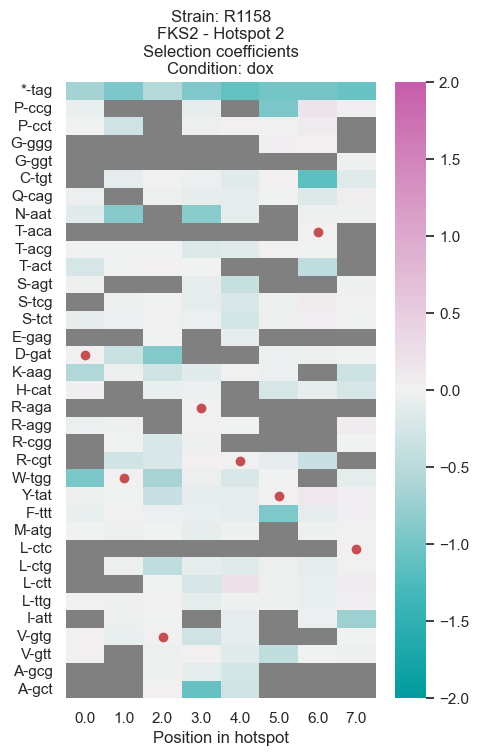

In [65]:
if pool_type == 'single':
    # Purge graph space
    sns.set(rc = {'figure.figsize':(5,8)})
    sns.set_theme(style='white')
    f, ax = plt.subplots()
    
    # Custom color palette
    ccmap = sns.color_palette("blend:#009B9E,#42B7B9,#A7D3D4,#F1F1F1,#E4C1D9,#D691C1,#C75DAB", # CARTOColors Tropic
                              as_cmap=True)
    ccmap.set_bad('.5') # Color for missing values
    
    # Mask for missing values
    mask = pd.isnull(wide_single)
    
    # Draw heatmap
    ax = sns.heatmap(wide_single, mask=mask,
                     cmap=ccmap, center = 0,
                     vmin=-2, vmax=2)
    ax.set_xlabel('Position in hotspot')
    ax.set_ylabel(None)
    ax.set_title('Strain: '+strain+
                 '\n'+locus[:4]+' - Hotspot '+locus[-1]+
                 '\nSelection coefficients'+
                 '\nCondition: '+compound)

    # Coordinates of WT codons on the heatmap are extracted from the dataframe
    # Coordinates should be OK even if some codons are missing from the dataframe
    codon_list = [x[1] for x in wide_single.index]
    wtcoord = [((i//3)+0.5,codon_list.index(wtseq[i:i+3])+0.5) for i in range(0,len(wtseq),3)]

    for o in wtcoord:
        ax.plot(o[0],o[1],'or') # displays WT codons by marking them with red (r) circles (o)

    # Graphs are output in the specified folder
    plt.savefig(graph_outpath+cset_name+'/nt_heatmap_median_s.svg', format='svg', dpi=300)

### Aggregate at protein level

### Visualize single mutants as heatmap (protein level)

In [66]:
withWTdf_gby = withWTdf.groupby(['alt_aa','aa_pos','nt_seq'])[['median_s']].first().reset_index()

In [67]:
aa_single = withWTdf_gby.groupby(['alt_aa','aa_pos'])[['median_s']].median().reset_index()
wide_aa = aa_single.pivot(index='alt_aa', columns='aa_pos', values='median_s')
wide_aa.sort_index(key=lambda x: x.map(aa_sort_dic), inplace=True)
wide_aa

aa_pos,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0
alt_aa,,,,,,,,
*,-0.677616,-0.947858,-0.534785,-0.919109,-1.108709,-1.003124,-0.996232,-1.074878
P,-0.035377,-0.303103,NaN,-0.062930,0.023113,-0.472444,0.134803,0.032163
G,NaN,NaN,NaN,NaN,NaN,0.032563,0.020472,-0.023627
C,NaN,-0.097771,0.007267,-0.060913,-0.131233,0.020512,-1.145824,-0.147783
Q,-0.058505,NaN,-0.046442,-0.082818,-0.098085,-0.001328,-0.172086,0.052265
N,-0.140597,-0.870059,NaN,-0.857663,-0.111818,NaN,-0.038119,-0.021068
T,-0.129149,-0.011215,0.005878,-0.093274,-0.143917,0.009693,-0.003141,NaN
S,-0.059307,-0.040586,-0.002018,-0.078539,-0.263860,-0.019663,0.057021,-0.002827
E,NaN,NaN,-0.006604,NaN,-0.084021,NaN,NaN,NaN


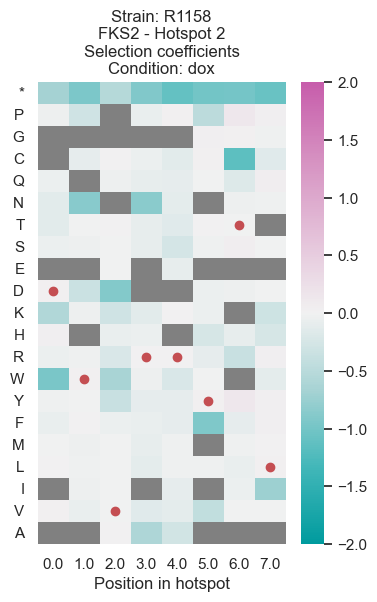

In [68]:
# Purge graph space
sns.set(rc = {'figure.figsize':(4,6),
             })
sns.set_theme(style='white')
f, ax = plt.subplots()

# Custom color palette
ccmap = sns.color_palette("blend:#009B9E,#42B7B9,#A7D3D4,#F1F1F1,#E4C1D9,#D691C1,#C75DAB", # CARTOColors Tropic
                          as_cmap=True)
ccmap.set_bad('.5') # Color for missing values

# Mask for missing values
mask = pd.isnull(wide_aa)

# Draw heatmap
ax = sns.heatmap(wide_aa, mask=mask, 
                 cmap=ccmap, center = 0,
                 vmin=-2,
                 vmax=2
                )
ax.set_xlabel('Position in hotspot')
ax.set_ylabel(None)
plt.yticks(rotation=0)
ax.set_title('Strain: '+strain+
             '\n'+locus[:4]+' - Hotspot '+locus[-1]+
             '\nSelection coefficients'+
             '\nCondition: '+compound)

# Coordinates of WT protein sequence on the heatmap are extracted from the dataframe
# Coordinates should be OK even if the dataframe contains missing values
wtcoord_aa = [(i+0.5, list(aa_sort_order).index(v)+0.5) for i,v in enumerate(wtaa)]

for o in wtcoord_aa:
    ax.plot(o[0],o[1],'or') # displays WT codons by marking them with red (r) circles (o)
    
# Graphs are output in the specified folder
plt.savefig(graph_outpath+cset_name+'/aa_heatmap_median_s.svg', format='svg', dpi=300)

### Compare with DiMSum-corrected fitness values

For some samples, there was no fitness values calculated by DiMSum. There's no easy way to solve this until [this PR](https://github.com/nteract/papermill/pull/738) moves forward. Which means I have to put an if upstream of every following cell.

In [69]:
dimsum_fpath = f'{dimsumfitness_path}/fitness_{pool_type}s_{cset_name}.txt'
if os.path.exists(dimsum_fpath):
    dimsum = pd.read_csv(dimsum_fpath, sep=' ')
    display(dimsum)

,Pos,WT_AA,Mut,nt_seq,aa_seq,Nham_nt,Nham_aa,Nmut_codons,STOP,STOP_readthrough,mean_count,fitness,sigma
0,1,D,T,NaN,TWVRRYTL,NaN,1,NaN,False,False,837.333333,-0.020083,0.011116
1,1,D,R,NaN,RWVRRYTL,NaN,1,NaN,False,False,1219.666667,-0.066916,0.009995
2,1,D,S,NaN,SWVRRYTL,NaN,1,NaN,False,False,251.000000,-0.086960,0.017845
3,1,D,M,NaN,MWVRRYTL,NaN,1,NaN,False,False,279.000000,0.002820,0.016538
4,1,D,Q,NaN,QWVRRYTL,NaN,1,NaN,False,False,211.333333,-0.050494,0.018616
...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,1,D,V,NaN,VWVRRYTL,NaN,1,NaN,False,False,885.000000,0.010705,0.010854
114,1,D,Y,NaN,YWVRRYTL,NaN,1,NaN,False,False,1185.000000,-0.026275,0.010045
115,1,D,W,NaN,WWVRRYTL,NaN,1,NaN,False,False,269.666667,-0.995611,0.032084
116,1,D,L,NaN,LWVRRYTL,NaN,1,NaN,False,False,3169.000000,-0.009851,0.007778


In [70]:
if os.path.exists(dimsum_fpath):
    if pool_type == 'single':
        dimsum_long = dimsum
        dimsum_long['mutated_codon'] = 1
    else:
        dimsum_long = pd.wide_to_long(dimsum,
                                      stubnames = ['Pos', 'WT_AA', 'Mut', 'fitness', 'sigma'],
                                      i = ['aa_seq','Nham_aa','mean_count','fitness_uncorr','sigma_uncorr'],
                                      j = 'mutated_codon').reset_index()
    display(dimsum_long)

,Pos,WT_AA,Mut,nt_seq,aa_seq,Nham_nt,Nham_aa,Nmut_codons,STOP,STOP_readthrough,mean_count,fitness,sigma,mutated_codon
0,1,D,T,NaN,TWVRRYTL,NaN,1,NaN,False,False,837.333333,-0.020083,0.011116,1
1,1,D,R,NaN,RWVRRYTL,NaN,1,NaN,False,False,1219.666667,-0.066916,0.009995,1
2,1,D,S,NaN,SWVRRYTL,NaN,1,NaN,False,False,251.000000,-0.086960,0.017845,1
3,1,D,M,NaN,MWVRRYTL,NaN,1,NaN,False,False,279.000000,0.002820,0.016538,1
4,1,D,Q,NaN,QWVRRYTL,NaN,1,NaN,False,False,211.333333,-0.050494,0.018616,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,1,D,V,NaN,VWVRRYTL,NaN,1,NaN,False,False,885.000000,0.010705,0.010854,1
114,1,D,Y,NaN,YWVRRYTL,NaN,1,NaN,False,False,1185.000000,-0.026275,0.010045,1
115,1,D,W,NaN,WWVRRYTL,NaN,1,NaN,False,False,269.666667,-0.995611,0.032084,1
116,1,D,L,NaN,LWVRRYTL,NaN,1,NaN,False,False,3169.000000,-0.009851,0.007778,1


In [71]:
if os.path.exists(dimsum_fpath):
    dimsum_long.rename(columns={'Pos':'aa_pos', 'Mut':'alt_aa'}, inplace=True)
    dimsum_long['aa_pos']-=1
    display(dimsum_long)

,aa_pos,WT_AA,alt_aa,nt_seq,aa_seq,Nham_nt,Nham_aa,Nmut_codons,STOP,STOP_readthrough,mean_count,fitness,sigma,mutated_codon
0,0,D,T,NaN,TWVRRYTL,NaN,1,NaN,False,False,837.333333,-0.020083,0.011116,1
1,0,D,R,NaN,RWVRRYTL,NaN,1,NaN,False,False,1219.666667,-0.066916,0.009995,1
2,0,D,S,NaN,SWVRRYTL,NaN,1,NaN,False,False,251.000000,-0.086960,0.017845,1
3,0,D,M,NaN,MWVRRYTL,NaN,1,NaN,False,False,279.000000,0.002820,0.016538,1
4,0,D,Q,NaN,QWVRRYTL,NaN,1,NaN,False,False,211.333333,-0.050494,0.018616,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,0,D,V,NaN,VWVRRYTL,NaN,1,NaN,False,False,885.000000,0.010705,0.010854,1
114,0,D,Y,NaN,YWVRRYTL,NaN,1,NaN,False,False,1185.000000,-0.026275,0.010045,1
115,0,D,W,NaN,WWVRRYTL,NaN,1,NaN,False,False,269.666667,-0.995611,0.032084,1
116,0,D,L,NaN,LWVRRYTL,NaN,1,NaN,False,False,3169.000000,-0.009851,0.007778,1


In [72]:
if os.path.exists(dimsum_fpath):
    ntdf = withSyndf[withSyndf.Nham_aa == nhamaa 
    ].groupby(['aa_seq','mutated_codon','Nham_aa','aa_pos','alt_aa','nt_seq'],
             ).agg(median_s = ('median_s', 'first'),
                   cscore = ('confidence_score', 'first')
                  ).reset_index()
    display(ntdf)

,aa_seq,mutated_codon,Nham_aa,aa_pos,alt_aa,nt_seq,median_s,cscore
0,*WVRRYTL,1.0,1.0,0.0,*,tagtgggtgagacgttatacactc,-0.677616,2.0
1,D*VRRYTL,1.0,1.0,1.0,*,gattaggtgagacgttatacactc,-0.947858,1.0
2,DCVRRYTL,1.0,1.0,1.0,C,gattgtgtgagacgttatacactc,-0.097771,1.0
3,DDVRRYTL,1.0,1.0,1.0,D,gatgatgtgagacgttatacactc,-0.356454,1.0
4,DFVRRYTL,1.0,1.0,1.0,F,gattttgtgagacgttatacactc,0.015588,1.0
...,...,...,...,...,...,...,...,...
177,TWVRRYTL,1.0,1.0,0.0,T,acttgggtgagacgttatacactc,-0.245067,3.0
178,VWVRRYTL,1.0,1.0,0.0,V,gtgtgggtgagacgttatacactc,0.026298,1.0
179,VWVRRYTL,1.0,1.0,0.0,V,gtttgggtgagacgttatacactc,0.021779,1.0
180,WWVRRYTL,1.0,1.0,0.0,W,tggtgggtgagacgttatacactc,-0.963859,1.0


In [73]:
if os.path.exists(dimsum_fpath):
    aadf = ntdf.groupby(['aa_seq','mutated_codon','Nham_aa','aa_pos','alt_aa']
                       ).agg(median_s = ('median_s', 'median'),
                             cscore = ('cscore', 'min')
                            ).reset_index()
    display(aadf)

,aa_seq,mutated_codon,Nham_aa,aa_pos,alt_aa,median_s,cscore
0,*WVRRYTL,1.0,1.0,0.0,*,-0.677616,2.0
1,D*VRRYTL,1.0,1.0,1.0,*,-0.947858,1.0
2,DCVRRYTL,1.0,1.0,1.0,C,-0.097771,1.0
3,DDVRRYTL,1.0,1.0,1.0,D,-0.356454,1.0
4,DFVRRYTL,1.0,1.0,1.0,F,0.015588,1.0
...,...,...,...,...,...,...,...
134,SWVRRYTL,1.0,1.0,0.0,S,-0.059307,1.0
135,TWVRRYTL,1.0,1.0,0.0,T,-0.129149,1.0
136,VWVRRYTL,1.0,1.0,0.0,V,0.024039,1.0
137,WWVRRYTL,1.0,1.0,0.0,W,-0.963859,1.0


In [74]:
if os.path.exists(dimsum_fpath):
    dimsum_compare = pd.merge(left=aadf, right=dimsum_long, how='outer', on=['aa_seq','mutated_codon','Nham_aa','aa_pos','alt_aa'], indicator='Location')
    display(dimsum_compare)

,aa_seq,mutated_codon,Nham_aa,aa_pos,alt_aa,median_s,cscore,WT_AA,nt_seq,Nham_nt,Nmut_codons,STOP,STOP_readthrough,mean_count,fitness,sigma,Location
0,*WVRRYTL,1.0,1.0,0.0,*,-0.677616,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
1,D*VRRYTL,1.0,1.0,1.0,*,-0.947858,1.0,W,NaN,NaN,NaN,True,False,822.000000,-0.962514,0.018981,both
2,DCVRRYTL,1.0,1.0,1.0,C,-0.097771,1.0,W,NaN,NaN,NaN,False,False,76.000000,-0.148784,0.030482,both
3,DDVRRYTL,1.0,1.0,1.0,D,-0.356454,1.0,W,NaN,NaN,NaN,False,False,81.333333,-0.368826,0.032684,both
4,DFVRRYTL,1.0,1.0,1.0,F,0.015588,1.0,W,NaN,NaN,NaN,False,False,367.000000,0.018227,0.014720,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,SWVRRYTL,1.0,1.0,0.0,S,-0.059307,1.0,D,NaN,NaN,NaN,False,False,251.000000,-0.086960,0.017845,both
135,TWVRRYTL,1.0,1.0,0.0,T,-0.129149,1.0,D,NaN,NaN,NaN,False,False,837.333333,-0.020083,0.011116,both
136,VWVRRYTL,1.0,1.0,0.0,V,0.024039,1.0,D,NaN,NaN,NaN,False,False,885.000000,0.010705,0.010854,both
137,WWVRRYTL,1.0,1.0,0.0,W,-0.963859,1.0,D,NaN,NaN,NaN,False,False,269.666667,-0.995611,0.032084,both


In [75]:
# Check variants that did not merge
if os.path.exists(dimsum_fpath):
    display(dimsum_compare[dimsum_compare.Location != 'both'])

,aa_seq,mutated_codon,Nham_aa,aa_pos,alt_aa,median_s,cscore,WT_AA,nt_seq,Nham_nt,Nmut_codons,STOP,STOP_readthrough,mean_count,fitness,sigma,Location
0,*WVRRYTL,1.0,1.0,0.0,*,-0.677616,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
10,DPVRRYTL,1.0,1.0,1.0,P,-0.303103,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
15,DW*RRYTL,1.0,1.0,2.0,*,-0.534785,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
23,DWIRRYTL,2.0,1.0,4.0,R,-0.026936,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
24,DWIRRYTL,3.0,1.0,6.0,T,-0.026936,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
25,DWIRRYTL,4.0,1.0,7.0,L,-0.026936,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
33,DWTRRYTL,2.0,1.0,4.0,R,-0.021057,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
34,DWTRRYTL,3.0,1.0,6.0,T,-0.021057,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
35,DWTRRYTL,4.0,1.0,7.0,L,-0.021057,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
41,DWVKRYTL,1.0,1.0,3.0,K,-0.140597,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only


The following plot shows the correlation between the median selection coefficient (as calculated in this notebook) and the fitness value calculated by DiMSum.

The color corresponds to a homemade confidence score based on the input read count in ALL replicates:
- 1 = highest confidence = at worst 10 reads in all replicates
- 2 = good confidence = at worst 4 reads in any replicate
- 3 = lowest confidence = at most 3 reads in any replicate

The size of the dots corresponds to the error on the fitness value calculated by DiMSum:
- small = little error (std), therefore higher confidence
- big = larger error, therefore lower confidence

In [76]:
if os.path.exists(dimsum_fpath):
    if 'fitness_uncorr' in dimsum.columns:
        fitcol = 'fitness_uncorr'
        sigcol = 'sigma_uncorr'
    else:
        fitcol = 'fitness'
        sigcol = 'sigma'

    graphdf = dimsum_compare[dimsum_compare.Location == 'both'
                            ].groupby('aa_seq')[['median_s', fitcol, sigcol, 'cscore']
                                               ].agg(x = ('median_s', 'first'),
                                                     y = (fitcol, 'first'),
                                                     h = ('cscore', 'first'),
                                                     s = (sigcol, 'first')
                                                    ).reset_index()
    display(graphdf)

,aa_seq,x,y,h,s
0,D*VRRYTL,-0.947858,-0.962514,1.0,0.018981
1,DCVRRYTL,-0.097771,-0.148784,1.0,0.030482
2,DDVRRYTL,-0.356454,-0.368826,1.0,0.032684
3,DFVRRYTL,0.015588,0.018227,1.0,0.014720
4,DIVRRYTL,-0.032778,-0.045308,1.0,0.009482
...,...,...,...,...,...
113,SWVRRYTL,-0.059307,-0.086960,1.0,0.017845
114,TWVRRYTL,-0.129149,-0.020083,1.0,0.011116
115,VWVRRYTL,0.024039,0.010705,1.0,0.010854
116,WWVRRYTL,-0.963859,-0.995611,1.0,0.032084


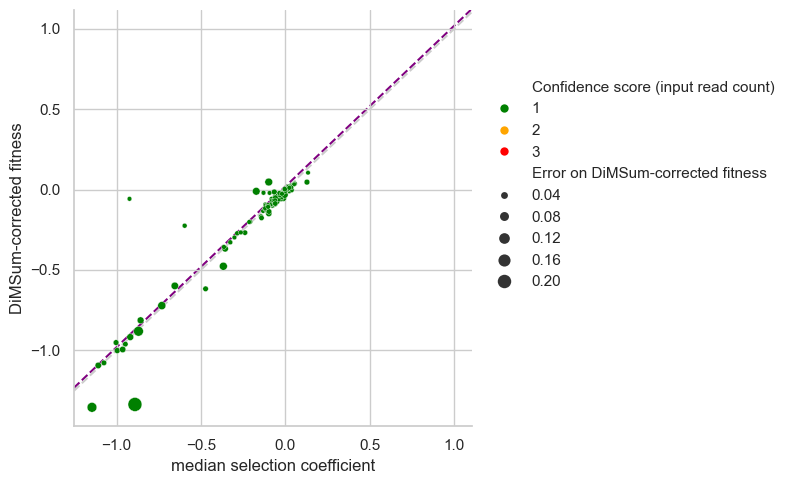

In [77]:
# Purge graph space
sns.set(rc = {'figure.figsize':(4,4)})
sns.set_theme(style='whitegrid')

if os.path.exists(dimsum_fpath):
    fig = sns.relplot(graphdf, x='x', y='y',
                      hue='h', hue_order=[1,2,3], palette=['green','orange','red'],
                      size='s', sizes=(10,100))
    fig.set(xlabel='median selection coefficient', ylabel='DiMSum-corrected fitness',)

    medianWToffset = withSyndf.median_s.iat[-1]
    fig.axes[0][0].axline((1,1), slope=1, linestyle='--', c='.8', zorder=-10)
    fig.axes[0][0].axline((1 - medianWToffset,1), slope=1, linestyle='--', c='purple', zorder=-20)
    fig._legend.texts[0].set_text('Confidence score (input read count)')
    fig._legend.texts[4].set_text('Error on DiMSum-corrected fitness')
    sns.move_legend(fig, bbox_to_anchor=(.85, 0.85), loc='upper left')

For NNK x NNK libraries, because there is more noise, the dots will almost surely be shifted from the (1,1) diagonal

This is because DiMSum normalizes values with the WT, instead of taking the median of synonymous variants (excluding the WT nucleotide sequence)

To confirm this, the diagonal in purple gives a rough estimate of where the values would fall if we had decided to normalize with the WT nucleotide sequence (median across replicates)